In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
W = 10
H = 5
d = H
V_eq = doulbe_well_width_height(xref, W, H, xavg, d)
F_eq = force_doulbe_well_width_height(xref, W, H, xavg)
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq

## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [4]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
# Read simulated trajectory from jld file
f_in = "../trajectory/doublewell_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
W = load(f_in, "W")
H = load(f_in, "H")
D = load(f_in, "D");

### Part 4: Do KDE and plot

In [6]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
peq_kde_estimate = gaussian_kde(xref, y_record, sigma_by_keq, w0);

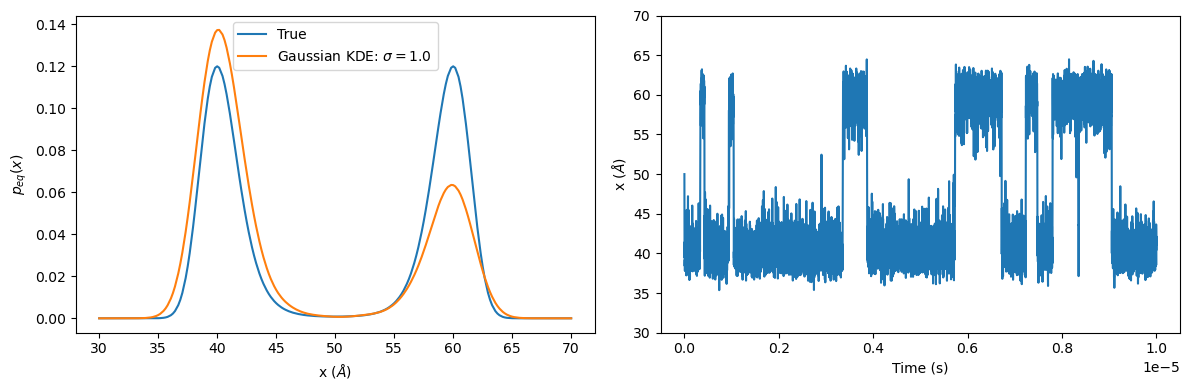

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, peq_kde_estimate, label="Gaussian KDE: \$\\sigma=1.0 \$")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()


ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

### Part 5: Forward Algorithm

In [7]:
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq_kde_estimate, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, Qx)
alpha_mat, beta_mat, Anorm_vec = get_mat_vec_v0(Nv, tau)

alpha_t0 = get_alpha_t0(weight_Qx, rho)
beta_t_tau = get_beta_t_tau(w0, rho, Qx, Nv)
atemp = alpha_t0
btemp = beta_t_tau

Anorm_vec[1] = norm(alpha_t0);

In [8]:
alpha_mat, Anorm_vec, atemp = forward_v0(alpha_mat, atemp, tau, y_record, Lambdas, Qx, dt, xref, e_norm, interpo_xs, Np, w0, Anorm_vec)
Anorm_vec[tau+2] = sum(btemp .* atemp)
atemp = atemp ./ Anorm_vec[end]
log_likelihood = sum(log.(Anorm_vec)); # Eq. (41)

### Part 6: Backward Algorithm

In [17]:
LQ_diff_ij = get_LQ_diff_ij(Nv, Lambdas) # Eq. (63) in JPCB 2013

expLQDT = exp.(-Lambdas .* dt)
someones = ones(1,Nv)
eLQDT = expLQDT * someones

beta_mat[:, end] = btemp
exp_ab_mat = zeros(Nv,Nv);

In [18]:
beta_idx = 1
y = y_record[beta_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)

psi_photon_psi = Qx' * photon_mat * Qx
btemp = psi_photon_psi * btemp
        
# Eq. (64) and Eq. (63)
outer= alpha_mat[:, beta_idx] * btemp'
exp_ab_mat = exp_ab_mat .+ outer .* ( diagm(expLQDT * dt) + LQ_diff_ij .* (eLQDT-eLQDT'))
        
btemp = expLQDT .* btemp
btemp = btemp / Anorm_vec[beta_idx]
beta_mat[:, beta_idx] = btemp;

In [23]:
btemp

72×1 Array{Float64,2}:
  8.01206470333905e-14
  4.78616137357189e-14
  5.3884651527366095e-14
 -1.0615582838550219e-13
 -1.3038856131249326e-15
  3.348229941583305e-14
 -4.5881188613378226e-14
 -9.852898314517703e-15
  2.095237888946943e-14
  2.095237888946943e-14
 -7.427917091470427e-14
 -6.6200119956418e-14
  1.5938913784288367e-14
  ⋮
 -8.374688135037657e-14
  3.423228850740958e-14
  3.423228850740958e-14
 -4.027942035907925e-14
 -4.027942035907925e-14
  1.4713669854446798e-13
  1.4713669854446798e-13
  9.724924644455413e-14
  9.724924644455413e-14
  2.374009039363863e-13
  2.1465396006870783e-13
  9.83527374046042e-14

In [12]:
for beta_idx in tau:-1:1
    y = y_record[beta_idx+1]
    photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)

    psi_photon_psi = Qx' * photon_mat * Qx
    btemp = psi_photon_psi * btemp
        
    # Eq. (64) and Eq. (63)
    outer= alpha_mat[:, beta_idx] * btemp'
    exp_ab_mat = exp_ab_mat .+ outer .* ( diagm(expLQDT * dt) + LQ_diff_ij .* (eLQDT-eLQDT'))
        
    btemp = expLQDT .* btemp
    btemp = btemp / Anorm_vec[beta_idx]
    beta_mat[:, beta_idx] = btemp
end

LoadError: UndefVarError: outer not defined

In [18]:
Qx * exp_ab_mat * Qx'

193×193 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  Na

In [15]:
exp_ab_mat = backward_v0(Lambdas, dt, Nv, beta_mat, btemp, tau, y_record, alpha_mat, xref, e_norm, interpo_xs, Np, w0, Qx, Anorm_vec)

# Eq. (72) and Eq. (78)
peq_new = diag(Qx * exp_ab_mat * Qx')
peq_new_normalize = peq_new ./ sum(w0 .* peq_new);

### Part 5: Eigendecomposition for KDE estimation

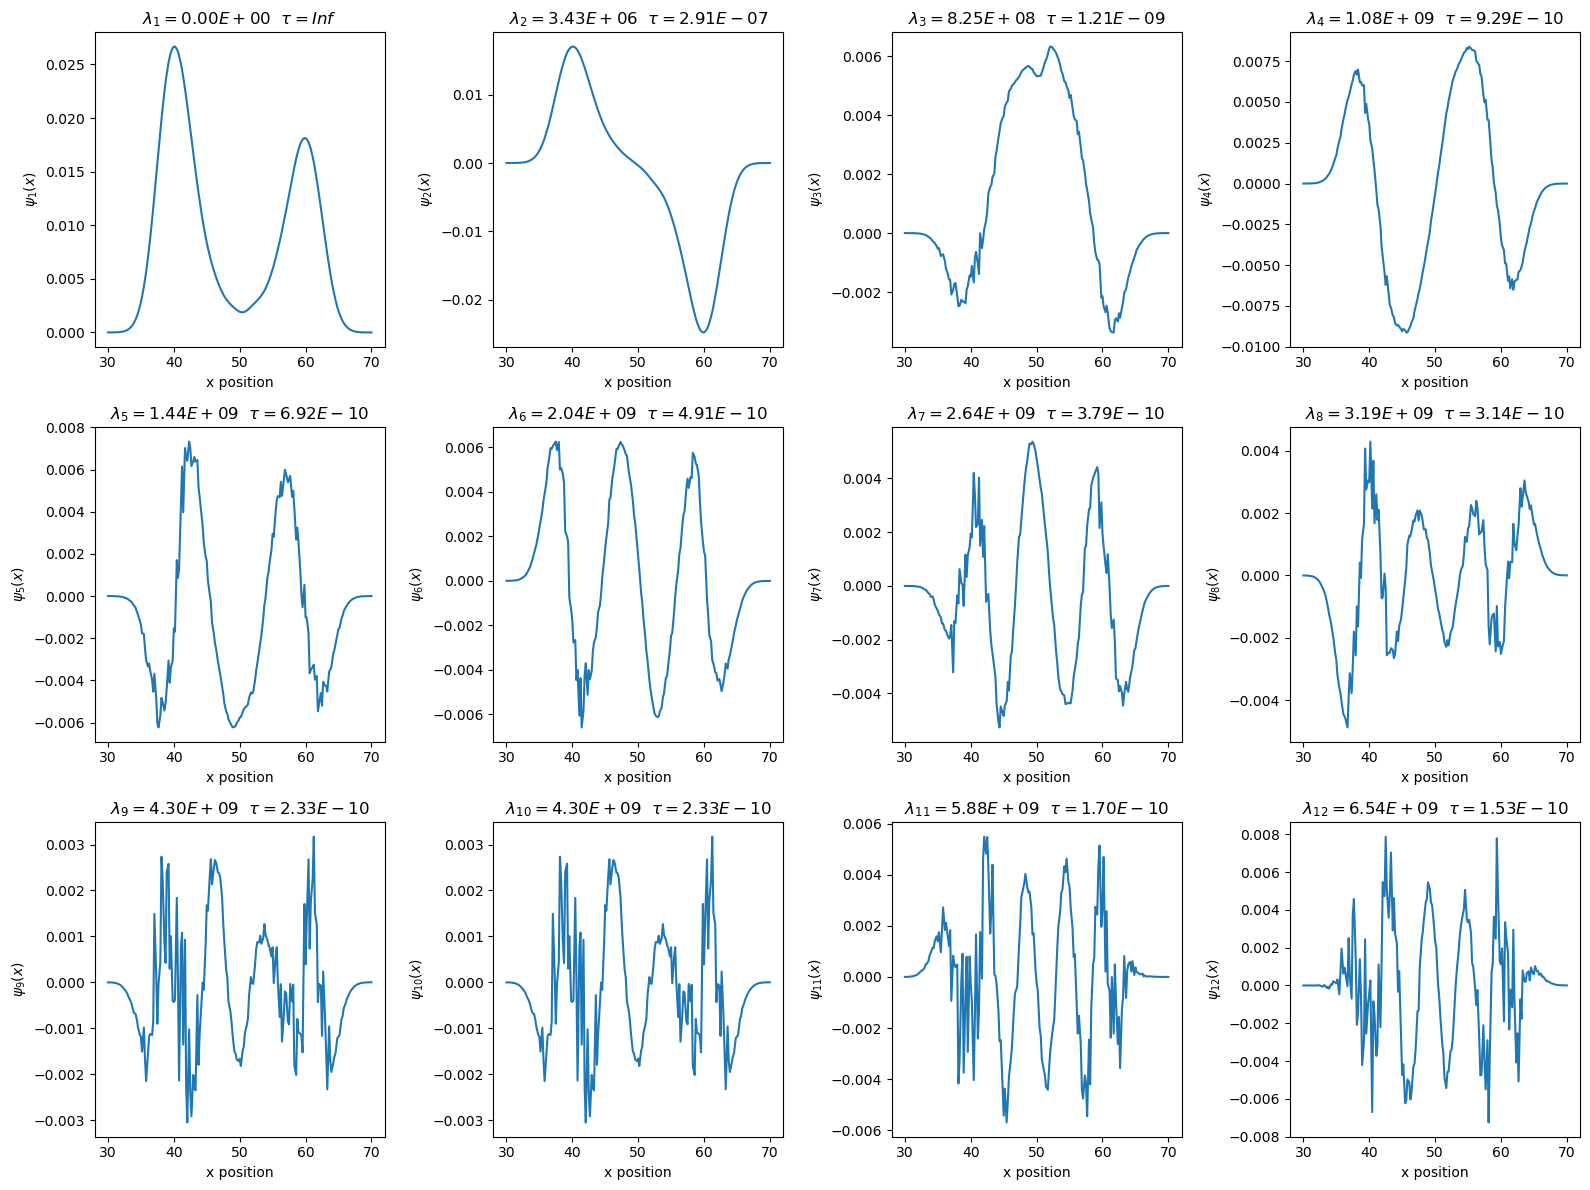

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

idx_eigvector = 1
for row_id=1:3
    for col_id = 1:4
        ax = axes[row_id, col_id]
        plot_x_Qx_lambda(ax, idx_eigvector, LQ, Qx, xref)
        idx_eigvector += 1
    end
end
plt.tight_layout()
#plt.savefig("eigv_1_12.png", dpi=150)
plt.show()

### Part 6: EM-1

In [ ]:
peq_kde_estimate = max.(peq_kde_estimate, 1e-10)
p_em_1, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, peq_kde_estimate, D, Nv, tau, y_record, save_freq);

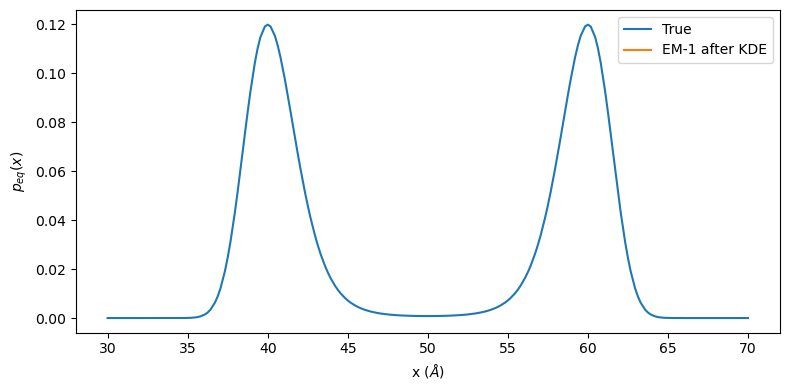

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_em_1, label="EM-1 after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()

In [69]:
p_em_1

193-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [63]:
peq_kde_estimate

193×1 Array{Float64,2}:
 1.0e-10
 1.2715658733701288e-10
 5.390164382271088e-10
 1.2689461108726715e-9
 2.9062352429399517e-9
 1.048746115550893e-8
 2.2384157415707416e-8
 4.654035111284083e-8
 1.4408444501296898e-7
 2.803835806911706e-7
 5.325661612482692e-7
 1.4311750828343018e-6
 2.560111077993356e-6
 ⋮
 7.853742063227343e-7
 2.891809018112182e-7
 1.5088730760269292e-7
 7.671186334199774e-8
 2.426982450684445e-8
 1.1502246691864767e-8
 5.3033526793169554e-9
 1.4284963903849674e-9
 6.12050775271288e-10
 2.5488903009654904e-10
 1.0e-10
 1.0e-10